#### Preparation of the benchmark datasets: solution of ODEs, merge of the existing solutions with their grids and some info about the processes.

In [5]:
import os
import sys
from typing import Callable, List, Tuple

path = os.path.abspath('')
print(path)
sys.path.pop() 
sys.path.append(os.path.abspath(os.path.join(path, '../..')))

import numpy as np
import h5py

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = False

SMALL_SIZE = 12
mpl.rc('font', size=SMALL_SIZE)
mpl.rc('axes', titlesize=SMALL_SIZE)

/home/mikemaslyaev/Documents/EPDE/data/benchmarks


ModuleNotFoundError: No module named 'PIL'

### Oridnary Differential Equations

#### I. Oridnary Differential Equation with trigonometric coefficients

$x \sin{t} + \frac{d x}{d t} \cos{t} = 1$ ODE with the initial condition $x(0) = 1.3$ (thus, $C = 1.3$) on the uniform grid with 200 nodes in the interval $(0, 4 \pi)$:

Solution - analytical: $ x = \sin{t} + 1.3 \cos{t}$

In [2]:
from dataclasses import dataclass
from typing import Union, List, Tuple

@dataclass
class Benchmark:
    name: str   # Name of the experiment, providing the benchmark dataset
    grid: Union[np.ndarray, List[np.ndarray]]   # Grids, on which the solution is provided. Can be single np.ndarray for ODE of list of arrays for PDEs
    values: Union[np.ndarray, List[np.ndarray]] # Solution of the equations. Can be single np.ndarray (if single equation case) of list of arrays for systems
    derivatives_information: List = None   # Optional. Description of the derivatives, passed 
    derivatives: Union[np.ndarray, List[Union[np.ndarray, List[np.ndarray]]]] = None    # Optional. Arrays of derivatives

    def combine_into_h5py(file: h5py._hl.files.File):
        

SyntaxError: incomplete input (3348862984.py, line 13)

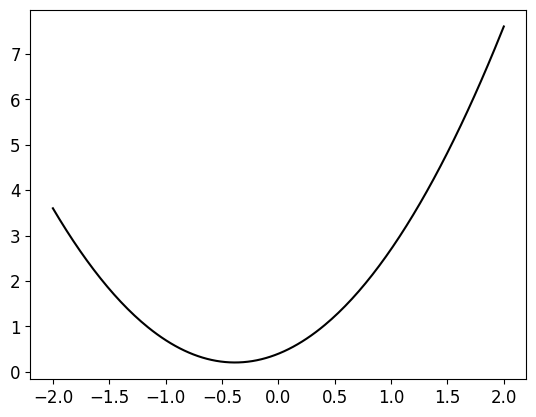

Surface training t=0, loss=2.1804860830307007
Surface training t=1, loss=2.1064103841781616
Surface training t=2, loss=2.0330026149749756
Surface training t=3, loss=1.9598303437232971
Surface training t=4, loss=1.9007620811462402
Surface training t=5, loss=1.8480871319770813
Surface training t=6, loss=1.8030731081962585
Surface training t=7, loss=1.765022873878479
Surface training t=8, loss=1.7307296991348267
Surface training t=9, loss=1.6954336166381836
Surface training t=10, loss=1.6639872789382935
Surface training t=11, loss=1.6366354823112488
Surface training t=12, loss=1.6123406291007996
Surface training t=13, loss=1.5880475640296936
Surface training t=14, loss=1.5694395303726196
Surface training t=15, loss=1.5490462183952332
Surface training t=16, loss=1.5347667336463928
Surface training t=17, loss=1.5220064520835876
Surface training t=18, loss=1.5097975134849548
Surface training t=19, loss=1.4993199110031128
Surface training t=20, loss=1.489253282546997
Surface training t=21, lo

/home/mikemaslyaev/Documents/EPDE/epde/preprocessing/smoothers.py:101: UserWarning: Returning ANN from smoother. This should not occur anywhere, except selected experiments.
  warn('Returning ANN from smoother. This should not occur anywhere, except selected experiments.')


In [11]:
A = 1.3; B = 1.; C = 0.4 
t = np.linspace(-2, 2, 200)
x = A * t ** 2 + B * t + C
plt.plot(t, x, color = 'k', label = 'x(t)')
plt.show()

from epde.preprocessing.smoothers import ANNSmoother

smoother = ANNSmoother()
approx, ann = smoother(x.reshape((1, -1)), t.reshape((1, -1)), epochs_max=1e4, return_ann = True)

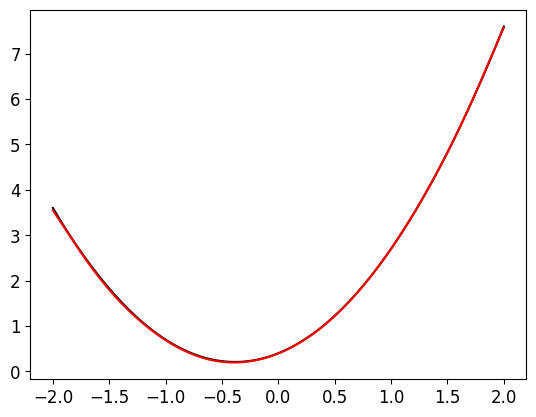

In [12]:
plt.plot(t, x, color = 'k', label = 'x(t)')
plt.plot(t, approx.reshape(-1), color = 'r', label = 'x(t) by ann')
plt.show()

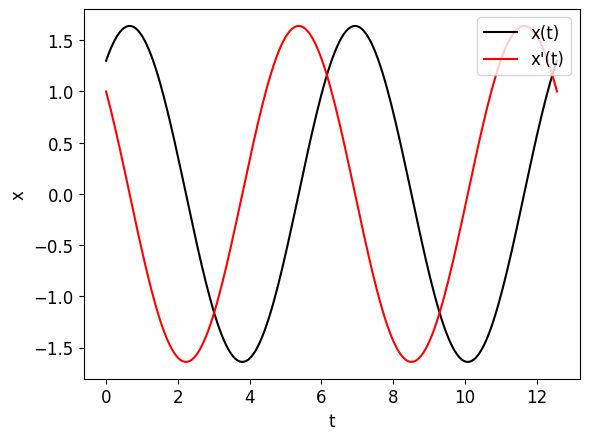

In [5]:
C = 1.3
t = np.linspace(0, 4*np.pi, 200)
x = np.sin(t) + C * np.cos(t)
x_dot = np.cos(t) - C * np.sin(t)
x_dot_dot = -np.sin(t) - C * np.cos(t)
x_dot_dot_dot = -np.cos(t) + C * np.sin(t)
max_axis_idx = x.ndim - 1

plt.plot(t, x, color = 'k', label = 'x(t)')
plt.plot(t, x_dot, color = 'r', label = "x'(t)")

plt.legend(loc = 'upper right')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

In [38]:
deriv_keys = ['x_dot', 'x_dot_dot', 'x_dot_dot_dot']
orders = [np.array([0,]), np.array([0, 0]), np.array([0, 0, 0])]
arrays = [x_dot, x_dot_dot, x_dot_dot_dot]

with h5py.File('ODE_trig.hdf5', 'w') as f:
    dataset_t = f.create_dataset('grid', data=[t,])
    dataset_x = f.create_dataset('vals', data=[x,])
    derivs_grouped = f.create_group('derivatives')
    for idx, key in enumerate(deriv_keys):
        derivs_subgrp = derivs_grouped.create_group(key)
        derivs_subgrp['var'] = 0
        derivs_subgrp['orders'] = orders[idx]
        derivs_subgrp['array'] = arrays[idx]

#### II. Second Order Oridnary Differential Equation 

$x'' + \sin{(2t)} x' + 4 x = 1.5 t$ ODE with the initial conditions $x|_{t = 0} = 0.8$, $x'|_{t = 0} = 2.0$ for domain $t \in [0, 16)$

Solution - numerical, with Runge-Kutta fourth order method.

In [55]:
def second_order_lODE_by_RK(initial : tuple, timestep : float, steps : int, g1 : Callable, 
                           g2 : Callable, g3 : Callable, g4 : Callable):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 = (g4(t) - g3(t)*res[step, 0] - g2(t)*res[step, 1]) / g1(t); y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = (g4(t) - g3(t)*x1 - g2(t)*y1) / g1(t); y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = (g4(t) - g3(t)*x2 - g2(t)*y2) / g1(t)
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = (g4(t) - g3(t)*x3 - g2(t)*y3) / g1(t)
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

To account for different coefficients, we generalize the structure as the equation $g_{1} x'' + g_{2} x' + g_{3} x = g_{4}$

In [56]:
g1 = lambda x: 1.
g2 = lambda x: np.sin(2*x)
g3 = lambda x: 4.
g4 = lambda x: 1.5*x

step = 0.05; steps_num = 320
t = np.arange(start = 0., stop = step * steps_num, step = step)
solution = second_order_lODE_by_RK(initial=(0.8, 2.), timestep=step, steps=steps_num, 
                                   g1=g1, g2=g2, g3=g3, g4=g4)

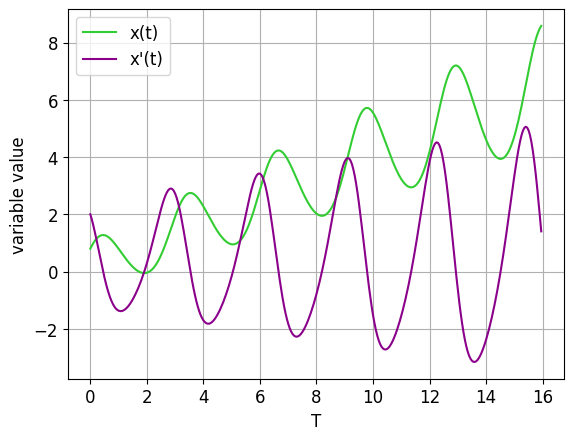

In [57]:
plt.plot(t, solution[:, 0], label = 'x(t)', color = 'limegreen')
plt.plot(t, solution[:, 1], label = "x'(t)", color = 'darkmagenta')
plt.grid(); plt.legend()
plt.xlabel('T'); plt.ylabel('variable value')
plt.show()

In [58]:
deriv_keys = [] # If necessary, calculate derivatives of the data
orders = []
arrays = []

with h5py.File('ODE_second_ord.hdf5', 'w') as f:
    dataset_t = f.create_dataset('grid', data=[t,])
    dataset_x = f.create_dataset('vals', data=[solution,])
    derivs_grouped = f.create_group('derivatives')
    for idx, key in enumerate(deriv_keys):
        derivs_subgrp = derivs_grouped.create_group(key)
        derivs_subgrp['var'] = 0
        derivs_subgrp['orders'] = orders[idx]
        derivs_subgrp['array'] = arrays[idx]

#### III. Van der Pol Oscillator

$u'' + \mathcal{E}(u^2 - 1)u' + u = 0$, where $\mathcal{E}$ is a positive constant (in the example we will use $\mathcal{E} = 0.2$), 
with initial conditions with $x|_{t = 0} = \sqrt{3}/2$, $x'|_{t = 0} = 0.5$ for 640 points in interval of domain $t \in [0, 32)$.

In [61]:
def VdP_by_RK(initial: tuple, timestep: float, steps: int, epsilon: float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 =  - epsilon*(res[step, 0]**2 - 1)*res[step, 1] - res[step, 0]; y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = - epsilon*(x1**2 - 1)*y1 - x1; y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = - epsilon*(x2**2 - 1)*y2 - x2
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = - epsilon*(x3**2 - 1)*y3 - x3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

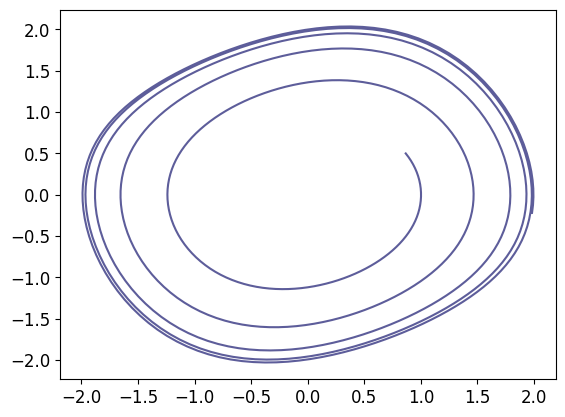

In [72]:
def prepare_VdP_data(initial = (np.sqrt(3)/2., 1./2.), step = 0.05, steps_num = 640, epsilon = 0.2):
    t = np.arange(start = 0., stop = step * steps_num, step = step)
    solution = VdP_by_RK(initial=initial, timestep=step, steps=steps_num, 
                                      epsilon=epsilon)
    return t, solution

t, x_stacked = prepare_VdP_data()

plt.plot(x_stacked[:, 0], x_stacked[:, 1], color = 'midnightblue', alpha = 0.7)
plt.show()

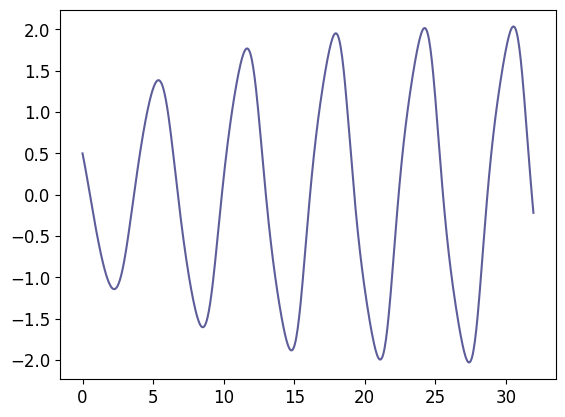

In [74]:
plt.plot(t, x_stacked[:, 0], color = 'midnightblue', alpha = 0.7)
plt.show()

In [ ]:
deriv_keys = ['x_dot',]
orders = [np.array([0,]),]
arrays = [x_stacked[:, 1],]

with h5py.File('ODE_van_der_pol.hdf5', 'w') as f:
    dataset_t = f.create_dataset('grid', data=[t,])
    dataset_x = f.create_dataset('vals', data=[x_stacked[:, 0],])
    derivs_grouped = f.create_group('derivatives')
    for idx, key in enumerate(deriv_keys):
        derivs_subgrp = derivs_grouped.create_group(key)
        derivs_subgrp['var'] = 0
        derivs_subgrp['orders'] = orders[idx]
        derivs_subgrp['array'] = arrays[idx]

### Systems of Ordinary Differential equations

#### I. Lotka-Volterra (hunter-prey) system

System of equations $\dot{u} = \alpha u - \beta u v; \; \dot{v} = \gamma u v - \delta v$, where $u$ is the population of prey species, $v$ - population of hunters and $\alpha, \beta, \gamma, \delta$ - positive parameters. System of equations is solved with initial conditions 

In [69]:
def Lotka_Volterra_by_RK(initial : Tuple[float], timestep : float, steps : int, alpha : float, 
                         beta : float, delta : float, gamma : float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        # print(res[step, :])
        k1 = alpha * res[step, 0] - beta * res[step, 0] * res[step, 1]; x1 = res[step, 0] + timestep/2. * k1
        l1 = delta * res[step, 0] * res[step, 1] - gamma * res[step, 1]; y1 = res[step, 1] + timestep/2. * l1

        k2 = alpha * x1 - beta * x1 * y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = delta * x1 * y1 - gamma * y1; y2 = res[step, 1] + timestep/2. * l2

        k3 = alpha * x2 - beta * x2 * y2
        l3 = delta * x2 * y2 - gamma * y1
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = alpha * x3 - beta * x3 * y3
        l4 = delta * x3 * y3 - gamma * y3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

In [70]:
steps_num = 301; step = 1./steps_num
t = np.arange(start = 0, stop = step * steps_num, step = step)
solution = Lotka_Volterra_by_RK(initial=(4., 2.), timestep=step, steps=steps_num, 
                                alpha=20., beta=20., delta=20., gamma=20.)

In [75]:
deriv_keys = []
orders = []
arrays = []

with h5py.File('ODE_Lotka_Volterra.hdf5', 'w') as f:
    dataset_t = f.create_dataset('grid', data=[t,])
    dataset_x = f.create_dataset('vals', data=[solution[:, 0], solution[:, 1]])
    derivs_grouped = f.create_group('derivatives')
    for idx, key in enumerate(deriv_keys):
        derivs_subgrp = derivs_grouped.create_group(key)
        derivs_subgrp['var'] = 0
        derivs_subgrp['orders'] = orders[idx]
        derivs_subgrp['array'] = arrays[idx]

#### II. Lorenz oscillator

System of ordinary differential equations: 

In [76]:
from scipy.integrate import solve_ivp

def lorenz(t, x, sigma=10, beta=3, rho=30):
    return [sigma * (x[1] - x[0]), x[0] * (rho - x[2]) - x[1], x[0] * x[1] - beta * x[2]]

integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(
    lorenz, t_train_span, u0_train, t_eval=t_train, **integrator_keywords
).y.T

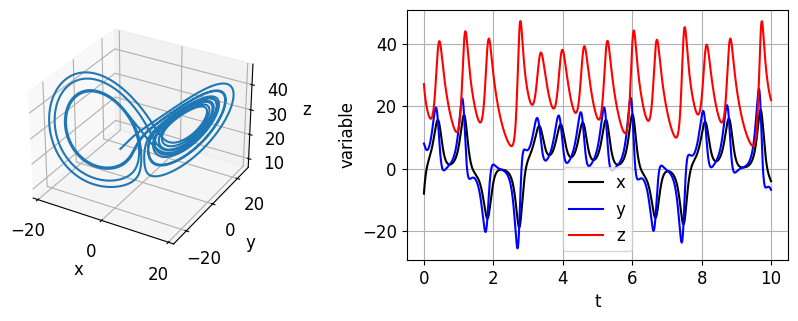

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].remove()
axs[0] = fig.add_subplot(1, 2, 1, projection='3d')
axs[0].plot(u_train[:, 0], u_train[:, 1], u_train[:, 2])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_zlabel('z')

axs[1].plot(t_train, u_train[:, 0], color = 'k', label = 'x')
axs[1].plot(t_train, u_train[:, 1], color = 'b', label = 'y')
axs[1].plot(t_train, u_train[:, 2], color = 'r', label = 'z')
axs[1].set_xlabel('t')
axs[1].set_ylabel('variable')
axs[1].grid()
axs[1].legend()
plt.subplots_adjust(left=0.1, bottom=0.4, right=0.8, top=0.9)
plt.show()